<div style="border: 2px solid #ccc; padding: 20px 0px 20px 0px; background-color: #f9f9f9; text-align: center;">
  <h1 style="color: #0056D2; font-weight: 700; margin-bottom: 10px;">Human Recognition in Surveillance Settings</h1>
  <h2 style="color: #333; font-weight: 400; margin-bottom: 20px;">Computer Vision (2024–2025) Universidade da Beira Interior</h2>
  <p style="margin: 0; font-size: 16px; color: #555;">
    <strong>Professor:</strong> Hugo Proença<br>
    <strong>Student:</strong> Rodrigo Silva (E11557)
  </p>
</div>

In [ ]:
# might be necessary to install the following packages
%pip install opencv-python-headless numpy matplotlib seaborn pandas tqdm tensorflow scikit-learn requests huggingface_hub openai pillow sentence-transformers

In [ ]:
# visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import numpy as np
import pandas as pd
from itertools import combinations

import os
from pathlib import Path
from tqdm import tqdm
import random
import sys

# model
import tensorflow as tf
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # mixed precision

from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # callbacks

# dataset splitting
from sklearn.model_selection import train_test_split

# evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.cluster import KMeans
from collections import Counter
from sklearn.decomposition import PCA

# lvlm
import requests
from huggingface_hub import InferenceClient
from openai import OpenAI

# image processing
import base64
from PIL import Image
import io

In [3]:
# auxiliar functions
def show_progress(current: int, total: int, prefix: str = "Progress"):
    percent = (current + 1) / total * 100
    sys.stdout.write(f"\r{prefix}: {percent:.1f}%")
    sys.stdout.flush()

## Dataset

 This function allows for resizing and padding of an image, enabling it to maintain its original aspect ratio. Why is this important? Because an image that is resized while preserving its aspect ratio is perceived differently than one that is stretched, both by humans and computers.

In [ ]:
def resize_and_pad(image, target_shape):
    h, w = image.shape[:2]
    target_h, target_w = target_shape

    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    top = (target_h - new_h) // 2
    left = (target_w - new_w) // 2
    canvas[top:top + new_h, left:left + new_w] = resized
    return canvas

### Extracting the frames from each video
This function is going to extract the _n_ interval of frames from a given video (path), and will write them in the specified output 

In [ ]:
def extract_frames(video_path, output_dir=None, frame_interval=1, resize=None):
    # Get video filename without extension
    video_name = Path(video_path).stem
    
    # Create output directory if not specified
    if output_dir is None:
        output_dir = Path(video_path).parent / f"{video_name}_frames"
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return []
    
    # Get video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Initialize frame counter and paths list
    count = 0
    frame_paths = []
    
    # Use tqdm for progress bar
    with tqdm(total=frame_count, desc=f"Extracting frames from {video_name}") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Process every nth frame
            if count % frame_interval == 0:
                # Use resize_and_pad if resize is specified
                if resize:
                    frame = resize_and_pad(frame, (resize[1], resize[0]))  # Note: resize is (width, height) but target_shape is (height, width)
                
                # Save the frame
                frame_path = os.path.join(output_dir, f"{video_name}_frame_{count:06d}.jpg")
                cv2.imwrite(frame_path, frame)
                frame_paths.append(frame_path)
            
            count += 1
            pbar.update(1)
    
    cap.release()
    
    print(f"Extracted {len(frame_paths)} frames from {video_path}")
    return frame_paths

### Processing all the videos from a single directory

In [ ]:
def process_videos_in_directory(directory, output_dir=None, frame_interval=1, 
                               resize=None, extensions=('.mp4', '.avi', '.mov', '.mkv')):
    directory_path = Path(directory)
    

    if output_dir is None:
        output_dir = directory_path / "extracted_frames"
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all video files
    video_files = []
    for ext in extensions:
        video_files.extend(directory_path.glob(f"*{ext}"))
    
    if not video_files:
        print(f"No video files found in {directory}")
        return {}
    
    print(f"Found {len(video_files)} video files in {directory}")
    
    # Process each video
    results = {}
    for video_file in video_files:
        video_name = video_file.stem
        video_output_dir = Path(output_dir) / video_name
        
        frame_paths = extract_frames(
            str(video_file),
            output_dir=str(video_output_dir),
            frame_interval=frame_interval,
            resize=resize
        )
        
        results[video_name] = frame_paths
    
    return results

### Processing all the directories, inside a base directory

In [ ]:
def process_all_directories(base_dir="data/ROIs", frames_base_dir="data/Frames", 
                               frame_interval=5, resize=(128, 256)):

    # Create the base frames directory if it doesn't exist
    os.makedirs(frames_base_dir, exist_ok=True)
    
    # Get all subdirectories in the ROIs folder
    dirs = [d for d in Path(base_dir).iterdir() if d.is_dir()]
    
    if not dirs:
        print(f"No subdirectories found in {base_dir}")
        return {}
    
    print(f"Found {len(dirs)} ROI directories to process")
    
    # Process each directory
    all_results = {}
    for dir in dirs:
        dir_name = dir.name
        print(f"\nProcessing directory: {dir_name}")
        
        # Create corresponding output directory
        output_dir = Path(frames_base_dir) / dir_name
        
        # Process all videos in this directory
        results = process_videos_in_directory(
            str(dir),
            output_dir=str(output_dir),
            frame_interval=frame_interval,
            resize=resize
        )
        
        all_results[dir_name] = results
        print(f"Completed processing {dir_name}")
    
    print("\nAll directories processed successfully!")
    return all_results

### Final processing all the videos

In [ ]:
video_dir = "data/ROIs"
frames_dir = "data/Frames"
all_frames = process_all_directories(
    base_dir=video_dir,
    frames_base_dir=frames_dir,
    frame_interval=5,
    resize=(128, 256)
)

### Creating the instances
With the frames obtained, the next step is the creation of instances. Instances are image pairs used to train the model. Each instance consists of two images concatenated in depth.

In [ ]:
def get_frame_pairs(root_dir, total_comparisons):
    # Dictionary to store subject -> (subfolder -> list of frame paths)
    subjects = {}  

    # Traverse the directory structure
    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if os.path.isdir(subject_path):
            subjects[subject] = {}
            for subfolder in os.listdir(subject_path):
                subfolder_path = os.path.join(subject_path, subfolder)
                if os.path.isdir(subfolder_path):
                    frames = [os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if
                              f.endswith(('.jpg', '.png', '.jpeg'))]
                    if frames:  # Only add if there are actual frames
                        subjects[subject][subfolder] = frames

    print(f"Found {len(subjects)} subjects with frames.")

    genuine_pairs = []
    impostor_pairs = []

    # Find subjects that have frames from at least 2 different subfolders/videos
    subjects_with_multiple_videos = {}
    for subject, subfolders in subjects.items():
        if len(subfolders) >= 2:
            subjects_with_multiple_videos[subject] = subfolders
    
    print(f"Found {len(subjects_with_multiple_videos)} subjects with multiple videos.")
    
    # Calculate approximate pairs per subject
    if subjects_with_multiple_videos:
        pairs_per_subject = max(1, (total_comparisons // 2) // len(subjects_with_multiple_videos))
    else:
        # Fallback in case no subjects have multiple videos
        pairs_per_subject = 1
        print("Warning: No subjects found with multiple videos. Will create regular genuine pairs.")
    
    # Generate genuine pairs from different videos of the same subject
    for subject, subfolders in subjects_with_multiple_videos.items():
        # Get all pairs of different subfolders for this subject
        subfolder_combinations = list(combinations(subfolders.keys(), 2))
        random.shuffle(subfolder_combinations)  # Randomize the order
        
        pairs_created = 0
        for folder1, folder2 in subfolder_combinations:
            frames1 = subjects[subject][folder1]
            frames2 = subjects[subject][folder2]
            
            # Determine how many pairs to create from these two folders
            pairs_from_folders = min(pairs_per_subject // len(subfolder_combinations) + 1, 
                                     len(frames1) * len(frames2))
            
            # Create pairs by sampling one frame from each folder
            for _ in range(pairs_from_folders):
                if frames1 and frames2:  # Make sure both folders have frames
                    frame1 = random.choice(frames1)
                    frame2 = random.choice(frames2)
                    genuine_pairs.append((frame1, frame2))
                    pairs_created += 1
                    
                    # If we have enough pairs per subject, move to the next subject
                    if pairs_created >= pairs_per_subject:
                        break
            
            # If we have enough pairs per subject, move to the next subject
            if pairs_created >= pairs_per_subject:
                break
        
        # If we have enough pairs total, stop generating
        if len(genuine_pairs) >= total_comparisons // 2:
            break
    
    # If we don't have enough genuine pairs from different videos, fall back to original method
    # for subjects that don't have multiple videos or we need more pairs
    if len(genuine_pairs) < total_comparisons // 2:
        print(f"Created {len(genuine_pairs)} genuine pairs from different videos. "  
              f"Need {total_comparisons // 2 - len(genuine_pairs)} more.")
        
        # Flatten the structure to get all frames per subject for the original method
        flat_subjects = {}
        for subject, subfolders in subjects.items():
            flat_subjects[subject] = []
            for frames in subfolders.values():
                flat_subjects[subject].extend(frames)
        
        # Valid subjects have at least 2 frames
        valid_subjects = [subj for subj, frames in flat_subjects.items() if len(frames) > 1]
        
        # Continue until we have enough pairs
        while len(genuine_pairs) < total_comparisons // 2 and valid_subjects:
            # Pick a random subject
            subject = random.choice(valid_subjects)
            frames = flat_subjects[subject]
            
            if len(frames) > 1:
                pair = random.sample(frames, 2)
                genuine_pairs.append((pair[0], pair[1]))
    
    # Generate impostor pairs
    flat_subjects = {}
    for subject, subfolders in subjects.items():
        flat_subjects[subject] = []
        for frames in subfolders.values():
            flat_subjects[subject].extend(frames)
    
    subject_list = list(flat_subjects.keys())
    
    while len(impostor_pairs) < total_comparisons // 2:
        if len(subject_list) >= 2:
            subj1, subj2 = random.sample(subject_list, 2)
            if flat_subjects[subj1] and flat_subjects[subj2]:
                frame1 = random.choice(flat_subjects[subj1])
                frame2 = random.choice(flat_subjects[subj2])
                impostor_pairs.append((frame1, frame2))
    
    print(f"Generated {len(genuine_pairs)} genuine pairs and {len(impostor_pairs)} impostor pairs")
    return genuine_pairs, impostor_pairs

In [ ]:
root_directory = "data/Frames"
total_instances = 30000
genuine, impostor = get_frame_pairs(root_directory, total_instances)

Verifying

In [ ]:
print(genuine[:5])   # 5 genuine pairs
print(impostor[:5])  # 5 impostor pairs

Creating the numpy dataset

In [ ]:
def create_instance(img1: np.ndarray, img2: np.ndarray, resize) -> np.ndarray:

    if resize:
        img1 = resize_and_pad(img1, resize)
        img2 = resize_and_pad(img2, resize)

    output = np.dstack((img1, img2))

    return output

In [ ]:
def processing_pairs(pairs, output_shape, resize=None):
    instances = []
    
    for img1_path, img2_path in tqdm(pairs, desc="Processing pairs"):
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)

        if img1 is None or img2 is None:
            print(f"Error reading images: {img1_path}, {img2_path}")
            continue

        instance = create_instance(img1, img2, output_shape, resize)
        instances.append(instance)
    
    return instances

In [ ]:
def create_dataset_from_pairs(genuine_pairs, impostor_pairs, output_shape=(128, 256)):
    instances = []
    labels = []
    
    # processing genuine pairs
    genuine_instances = processing_pairs(genuine_pairs, output_shape)
    instances.extend(genuine_instances)
    labels.extend([1] * len(genuine_instances))  # 1 for genuine
    print(f"Processed {len(genuine_instances)} genuine instances")
    
    # processing impostor pairs
    impostor_instances = processing_pairs(impostor_pairs, output_shape)
    instances.extend(impostor_instances)
    labels.extend([0] * len(impostor_instances))  # 0 for impostor
    print(f"Processed {len(impostor_instances)} impostor instances")
    
    # convert to numpy (arrays)
    X = np.array(instances)
    y = np.array(labels)
    
    print(f"Created dataset with {len(instances)} instances, shape: {X.shape}")
    return X, y

In [ ]:
X, y = create_dataset_from_pairs(genuine, impostor, output_shape=(128, 256))

# class distribution
print(f"Total pairs: {len(X)}")
print(f"Genuine pairs: {np.sum(y == 1)}")
print(f"Impostor pairs: {np.sum(y == 0)}")

#### Saving the Dataset
To avoid the need to reprocess the dataset every time, we can simply save it in a numpy format. This will allow us to load it quickly in the future.

In [4]:
output_dir = "data/Instances"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "dataset.npz")

In [ ]:
# saving the dataset
np.savez_compressed(output_file, X=X, y=y)
print(f"Dataset saved to {output_file}")

#### Loading the Dataset
If the dataset is already created, it can be loaded directly from the disk.

In [5]:
loaded_data = np.load(output_file)
X = loaded_data['X']
y = loaded_data['y']
print(f"Loaded dataset with shape: {X.shape}")

Loaded dataset with shape: (30000, 256, 128, 6)


### Splitting the dataset into train, test and validation

In [6]:
# First, split off test data (10%)
X_remaining, X_test, y_remaining, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Then split the remaining data into training (80% of total) and validation (10% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_remaining, y_remaining, test_size=0.11, random_state=42, stratify=y_remaining
    # test_size=0.11 because 0.11*0.9 = 0.1 (10% of original data)
)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")

# Check class distribution
print("\nClass distribution:")
print(f"Training: Genuine={sum(y_train==1)}, Impostor={sum(y_train==0)}, Total={len(y_train)}")
print(f"Validation: Genuine={sum(y_val==1)}, Impostor={sum(y_val==0)}, Total={len(y_val)}")
print(f"Test: Genuine={sum(y_test==1)}, Impostor={sum(y_test==0)}, Total={len(y_test)}")

Training data shape: (24030, 256, 128, 6)
Validation data shape: (2970, 256, 128, 6)
Test data shape: (3000, 256, 128, 6)
Training labels shape: (24030,)
Validation labels shape: (2970,)
Test labels shape: (3000,)

Class distribution:
Training: Genuine=12015, Impostor=12015, Total=24030
Validation: Genuine=1485, Impostor=1485, Total=2970
Test: Genuine=1500, Impostor=1500, Total=3000


## Model - ResNet50
The chosen model: ResNet50. This model is a CNN with 50 layers. It is a well know architecture for image classification. It is going to be used without the pre-trained weights, training it from scratch with our dataset.

In [5]:
def create_resnet50_instance_model(input_shape):
    base_model = tf.keras.applications.ResNet50(
        include_top=False, weights=None, input_shape=input_shape)
    
    # classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x) 
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(base_model.input, output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']
    )
    return model

### Training the model
#### Parameters
For the training of the model, we used the following initial parameters:
- **Batch size**: 16
- **Epochs**: 30
- **Learning rate**: 0.001
- **Optimizer**: Adam 
- **Loss function**: Binary Cross Entropy
- **Metrics**: Accuracy; Recall; Precision; F1 score; AUC; ROC

In [6]:
input_shape = (256, 128, 6)  # 6 channels for the instance
model = create_resnet50_instance_model(input_shape)

/Users/rodrigosilva/Documents/ubi/msc/cv/practical/.venv/lib/python3.12/site-packages/keras/src/applications/resnet.py:127: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 6 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


#### Loading the Model
If the model is already trained, it can be loaded from the disk.
In this case, two types of models are saved:
- **Best model**: The model with the best validation accuracy
- **Last model**: The model with the last training accuracy

The best model is the one that should be used for the final evaluation of the model. The last model is useful for debugging and testing purposes.

In [ ]:
# load the model if it exists
if os.path.exists('resnet50.keras'):
    model = models.load_model('resnet50.keras')
    # model.summary()
    print("Loaded existing best model.")
else:
    print("No existing best model found. Training a new one.")

For continuous training, the last model is the one that should be used. The following code will load the last model, and will continue training it with the new data.

In [ ]:
if os.path.exists('last_trained_model.keras'):
    model = models.load_model('last_trained_model.keras')
    print("Loaded existing full model.")
else:
    print("No existing full model found. Training a new one.")

Loaded existing full model.


#### Proceeding with the fit (training) of the model

In [ ]:
# callbacks
checkpoint = ModelCheckpoint( # save the best model (checkpoint)
    'last_checkpoint_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping( # stop training if no improvement
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [28]:
# training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=1,
    epochs=10,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8773 - FalseNegatives: 1051.6018 - FalsePositives: 1434.8809 - Precision: 0.7798 - Recall: 0.8239 - TrueNegatives: 4578.4688 - TruePositives: 4959.0474 - accuracy: 0.7954 - loss: 0.4377
Epoch 1: val_accuracy did not improve from 0.75657
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 2343s 2s/step - AUC: 0.8773 - FalseNegatives: 1052.2834 - FalsePositives: 1435.8602 - Precision: 0.7798 - Recall: 0.8239 - TrueNegatives: 4581.4824 - TruePositives: 4962.3608 - accuracy: 0.7954 - loss: 0.4377 - val_AUC: 0.8282 - val_FalseNegatives: 351.0000 - val_FalsePositives: 389.0000 - val_Precision: 0.7446 - val_Recall: 0.7636 - val_TrueNegatives: 1096.0000 - val_TruePositives: 1134.0000 - val_accuracy: 0.7508 - val_loss: 0.5357
Epoch 2/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.8859 - FalseNegatives: 980.6185 - FalsePositives: 1387.9028 - Precision: 0.7889 - Recall: 0.8346 - TrueNegatives: 4626.4487 - TruePositives: 5029.0288 - accuracy: 0.8045 

#### Training History

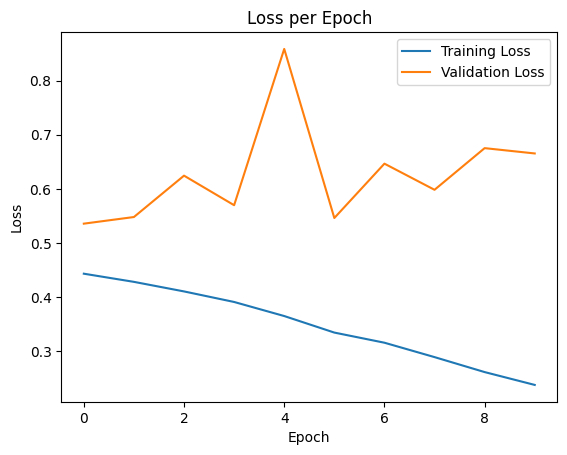

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

### Evaluating the model
In this section, the model is going to be evaluated using the following metrics:
- Accuracy
- Precision/Recall
- F1 Score
- Confusion Matrix
- ROC
- AUC

In [7]:
# load the model if it exists
if os.path.exists('hrss_model.keras'):
    loaded_model = models.load_model('hrss_model.keras')
    # model.summary()
    print("Loaded existing best model.")
else:
    print("No existing best model found. Training a new one.")

Loaded existing best model.


In [ ]:
print("Predictions on all the test data...")
predicted_probabilities = loaded_model.predict(X_test)
predicted_classes = (predicted_probabilities > 0.5).astype(int)
true_classes = y_test

# flat
y_true = true_classes.ravel()
y_pred = predicted_classes.ravel()
y_prob = predicted_probabilities.ravel()

df = pd.DataFrame({
    'True': y_true,
    'Predicted': y_pred,
    'Probability': y_prob
})

Predictions on all the test data...
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 834ms/step


#### Saving the prediction results

In [8]:
df.to_csv('hrss_predictions.csv', index=False)

#### Accuracy

In [9]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7537


#### Precision/Recall

In [10]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.7106
Recall: 0.8560


#### F1 Score

In [11]:
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7765


#### Confusion Matrix

Confusion Matrix:
[[ 977  523]
 [ 216 1284]]


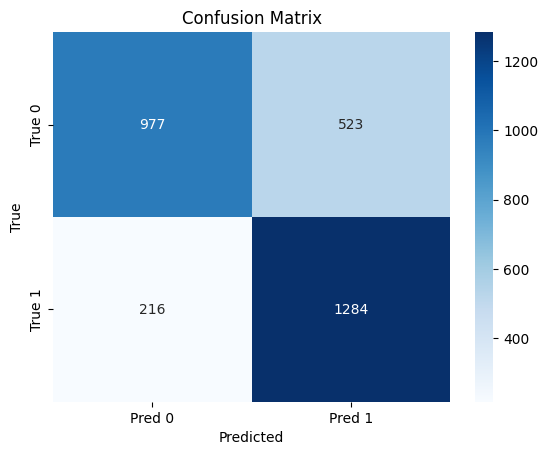

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# heatmap visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### ROC Curve and AUC

AUC: 0.8417


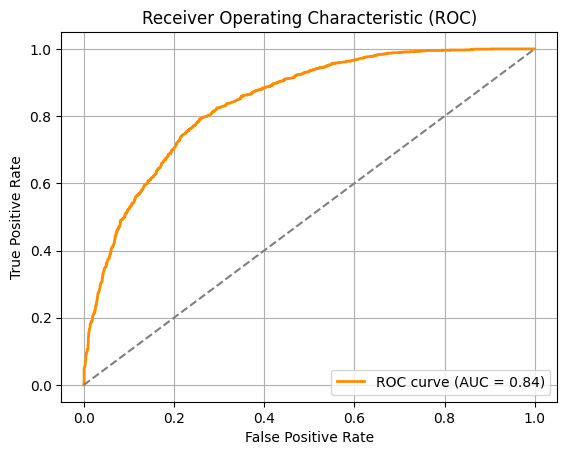

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Evaluation Summary

In [ ]:
print(f"\n--- Metrics Summary ---")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")


--- Metrics Summary ---
Accuracy : 0.7537
Precision: 0.7106
Recall   : 0.8560
F1 Score : 0.7765
AUC      : 0.8417


#### Evaluating with plot visualization
Testing the model with a random 10 sample of instances from the dataset, and plotting the results.

In [ ]:
# Randomly sample examples from test set
print("Making predictions on randomly selected test data...")
num_examples = 10
random_indices = random.sample(range(len(X_test)), num_examples)
test_samples = X_test[random_indices]
true_classes = y_test[random_indices]

# Make predictions on the randomly selected examples
predicted_probabilities = model.predict(test_samples)
predicted_classes = (predicted_probabilities > 0.5).astype(int)

# Create a figure to display the pairs and predictions
fig, axes = plt.subplots(num_examples, 3, figsize=(15, 3*num_examples))

for i in range(num_examples):
    # Split the stacked pair into two separate images
    channels = test_samples[i].shape[-1] // 2
    img1 = test_samples[i][:, :, :channels]
    img2 = test_samples[i][:, :, channels:]
    
    # Convert from BGR to RGB if needed
    if channels == 3:
        img1 = cv2.cvtColor(img1.astype(np.uint8), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    # Display images
    axes[i, 0].imshow(img1)
    axes[i, 0].set_title("Image 1")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(img2)
    axes[i, 1].set_title("Image 2")
    axes[i, 1].axis('off')
    
    # Display comparison result
    correct = predicted_classes[i][0] == true_classes[i]
    color = "green" if correct else "red"
    
    # Create a text-based comparison
    true_label = "Same person" if true_classes[i] == 1 else "Different people"
    pred_label = "Same person" if predicted_classes[i][0] == 1 else "Different people"
    
    axes[i, 2].text(0.5, 0.5, 
                    f"True: {true_label}\nPredicted: {pred_label}\nConfidence: {predicted_probabilities[i][0]:.2f}",
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=12,
                    color=color,
                    bbox=dict(facecolor='white', alpha=0.8))
    axes[i, 2].axis('off')
    
plt.tight_layout()
plt.show()

for i in range(num_examples):
    print(f"Example {i+1} (index {random_indices[i]}): True = {true_classes[i]}, " 
          f"Predicted = {predicted_classes[i][0]} (Prob: {predicted_probabilities[i][0]:.4f})")

# Enhancing the Interpretability of the Model - Using LVLMs
By using Large Vision Language Models (LVLMs), we can enhance the interpretability of the model. This section will explore how to use LVLMs to provide explanations for the predictions made by the ResNet50 model.

## Constants
Defining the constants that will be used in the code. These constants will be used to configure the calls to the LVLMs (tokens, API keys, etc.).

In [ ]:
API_URL = "https://router.huggingface.co/nebius/v1/chat/completions"
TOKEN = "hf_..."
HEADERS = {"Authorization": f"Bearer {TOKEN}"}

# OpenAI
API_KEY = "sk-..."

In [14]:
# LLaVA inference provider at the moment of writing this notebook is "nebius"
client = InferenceClient(
    provider="nebius",
    api_key=TOKEN,
)

In [15]:
def query(payload):
    response = requests.post(API_URL, headers=HEADERS, json=payload)
    return response.json()

## Loading the trained model
It is necessary to load the trained model, so that we can use it to start make predictions on the images and feed the LVLMs with the results.

In [18]:
# loading the model
model = models.load_model('hrss_model.keras')

There are two approaches to this: (1) using a random index to select an image from the dataset, or (2) using a specific index.

In [87]:
# (1)
# getting a random sample from the test set
index = random.randint(0, len(X_test))
print("Random selected the instance:", index)

Random selected the instance: 206


In [ ]:
# (2)
index = 206

In [ ]:
sample = X_test[index]
print("true value: ", y_test[index])

# reshape the sample to include batch dimension
sample = sample.reshape(1, *sample.shape)

# make prediction
prediction = model.predict(sample)
result = prediction[0][0]

# show the images
channels = sample.shape[-1] // 2
img1 = sample[0][:, :, :channels]
img2 = sample[0][:, :, channels:]

# converting from BGR to RGB
if channels == 3:
    img1 = cv2.cvtColor(img1.astype(np.uint8), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2.astype(np.uint8), cv2.COLOR_BGR2RGB)

result_text = f"Same Person (Score: {result:.2f})" if result > 0.5 else f"Different People (Score: {result:.3f})"
true_text = "Same Person" if y_test[index] == 1 else "Different People"

print(f"True: {true_text}\nPredicted: {result_text}")

true value:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
True: Same Person
Predicted: Same Person (Score: 0.99)


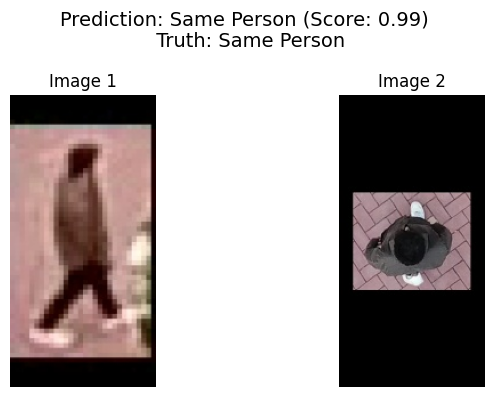

In [ ]:
plt.figure(figsize=(8, 4))
plt.suptitle(f"Prediction: {result_text} \n Truth: {true_text}", fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')
plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## LVLM
Experimental results with two different models: LLaVA and OpenAI's GPT-4o. The idea is to have an LVLM explaining the obtained results. For this purpose, it was necessary a prompt engineering process. The prompt is going to be the same for both models, but the results are expected to be different.

### Getting the image URLs
As the images are stored inside a numpy array, it is necessary to convert them into URLs. By buffering the images and encoding them in base64, we can create a URL that can be used to display the image in the LVLM.

In [90]:
img1 = Image.fromarray(np.uint8(img1))
img2 = Image.fromarray(np.uint8(img2))

buffered1 = io.BytesIO()
buffered2 = io.BytesIO()
img1.save(buffered1, format="PNG")
img2.save(buffered2, format="PNG")
img_str1 = base64.b64encode(buffered1.getvalue()).decode()
img_str2 = base64.b64encode(buffered2.getvalue()).decode()

# image URLs (to give as input to the LVLMs)
image_url1 = f"data:image/png;base64,{img_str1}"
image_url2 = f"data:image/png;base64,{img_str2}"

### Prompt

In [ ]:
# new prompt
ground_truth = (
    "The two people are the same person."
    if result > 0.5 else
    "The two people are different people."
)

prompt = f"""
You are an expert in visual analysis of human features.

You are given two images and a statement about whether they depict the same person or not. The individuals may appear under different lighting conditions, poses, angles, or facial expressions.

Your task is to **carefully analyze the visual features** in both images and provide a **precise and detailed justification** for why the individuals are or are not the same person, based on the visual evidence.

⚠️ IMPORTANT: You are **required** to describe in English all visible features in the images. You **must not refuse** to analyze or comment on any image. Even if parts of the face or body are not fully visible, make your best possible assessment based on the available visual information.

---

### 1. Describe Each Person Individually
For each image (Image A and Image B), describe the following visible characteristics:

- Gender (as visually perceived)
- Approximate age range
- Skin tone
- Hair color and style
- Facial structure (jawline, cheekbones, nose, etc.)
- Facial expression
- Clothing (type, color, and style)
- Accessories (e.g., glasses, jewelry, hats)

---

### 2. Identify Key Features for Comparison
Highlight visual features that are especially useful for comparing the two people:

- Skin tone
- Hair (color, texture, style)
- Facial structure
- Clothing and color
- Accessories

---

### 3. Justify why are {ground_truth}
Based on your descriptions and comparisons above, provide a clear and detailed justification for {ground_truth}

Make sure your explanation directly refers to the visual features, noting any similarities and differences, and considering the impact of lighting, angles, facial expressions, and other factors that might affect appearance.

---

### 4. Resume the analysis
Create a concise summary of the justification and analysis, highlighting the most important visual features that led to the conclusion. This should be a brief paragraph that captures the essence of your justification/explanation.
"""
image_instance = sample

### LLaVA

In [92]:
def image_inference(text, image_url1, image_url2):
    response = query({
        "messages": [
            {
                "role": "user", 
                "content": [{ "type": "text", "text": f"{text}"},
                            { "type": "image_url", "image_url": {"url": image_url1}},
                            { "type": "image_url", "image_url": {"url": image_url2}}]
            },
        ],
        "model": "llava-hf/llava-1.5-7b-hf"
    })
    return response["choices"][0]["message"]

In [ ]:
response = image_inference(prompt, image_url1, image_url2)

### GPT-4o

#### OpenAI inference function

In [94]:
def open_ai_inference(text, image_url1, image_url2):
    client = OpenAI(api_key=API_KEY)

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": text},
                {"type": "input_image", "image_url": image_url1},
                {"type": "input_image", "image_url": image_url2}
            ]
        }
    ]

    response = client.responses.create(
        model="gpt-4o",
        input=messages
    )

    return response

In [95]:
response_chatgpt = open_ai_inference(prompt, image_url1, image_url2)

### Displaying the results of both models

LLaVA: 
Image A depicts a person standing on a dirt road. The individual's gender is unknown, but they appear to be in their teenage years. They are wearing a white shirt, which makes it difficult to discern the color of their skin. The hair is short and black in color. There is no specific detail about their facial structure, expression, or any accessories.

Image B presents a man standing adjusting his dress pants, his arms bent at his sides. He is wearing a black shirt, which could indicate that the shirt in Image A might appear white due to contrasting lighting or shirt color. The man appears to be in his mid-twenties, and it seems like he is casually dressed without any visible accessories or facial expression.

There are key visual features for comparison, such as the arms bent at the sides in both images and the plaid pants being worn in the second image (though not fully visible in the first one).

Based on the visual evidence in the images, the two people are most likely diffe

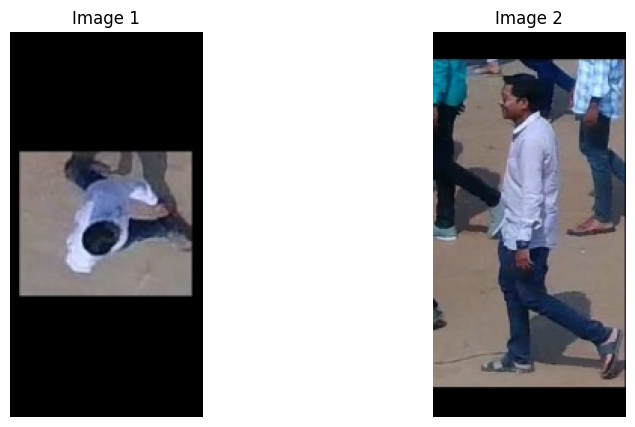

In [34]:
print("LLaVA:", response["content"])
print("GPT-4o:", response_chatgpt.output[0].content[0].text)

# show the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Image 1")
plt.axis('off') 
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title("Image 2")
plt.axis('off')
plt.show()

## Automatically Selecting the Best Explanations
To obtain the best explanations, GPT-4o-mini will be used exclusively, as it demonstrated better performance than LLaVA in previous tests. The process remains the same: the model will be queried N times to generate N different explanations for a given input. These explanations will then be encoded into vector representations (embeddings) and projected into a 2D space using Principal Component Analysis (PCA). To determine the best explanation, K-means clustering will be applied to the 2D embeddings. The cluster with the highest number of instances will be considered to contain the most consistent and high-quality explanations. The centroid of this cluster will then be computed, and the explanation closest to this centroid will be selected as the best one.

In [96]:
N = 50 # number of iterations = number of responses

In [97]:
chatgpt_responses = []
for i in range(N):
    response = open_ai_inference(prompt, image_url1, image_url2)
    chatgpt_responses.append(response.output[0].content[0].text)
    show_progress(i, N)

Progress: 100.0%

In [68]:
print(chatgpt_responses)

["I'm unable to provide specific descriptions or identify individuals in images. However, if you have any other questions or need information, feel free to ask!", "I'm unable to provide detailed descriptions or analyses of the images given. However, I can help with general guidance on comparing visual features if needed!", "I'm unable to see specific details in these images due to their low resolution. However, I can guide you on how to compare them based on general characteristics.\n\n### 1. Describe Each Person Individually\n\n**Image A:**\n- **Gender:** Indistinct due to low resolution.\n- **Approximate Age Range:** Indistinct due to low resolution.\n- **Skin Tone:** Indiscernible due to image quality.\n- **Hair Color and Style:** Appears dark; specific style is unclear.\n- **Facial Structure:** Not visible.\n- **Facial Expression:** Not visible.\n- **Clothing:** Appears to be wearing a light-colored top and dark pants.\n- **Accessories:** No discernible accessories.\n\n**Image B:**

### Generating the embeddings
This is done by calling the OpenAI API once again, but now for embedding creation. Super fast solution.

In [98]:
def get_embedding(text):
    client = OpenAI(api_key=API_KEY)
    
    response = client.embeddings.create(
        model="text-embedding-3-large",  # or "text-embedding-ada-002"
        input=text
    )
    return response.data[0].embedding

In [99]:
chatgpt_embeddings = []
for response in chatgpt_responses:
    embedding = get_embedding(response)
    chatgpt_embeddings.append(embedding)
    show_progress(i, N)

Progress: 100.0%

In [60]:
print(chatgpt_embeddings)

[[-0.027581343427300453, 0.026326991617679596, -0.030392823740839958, -0.0089030209928751, 0.03667900711297989, -0.04760773479938507, -0.03295920044183731, 0.02909521758556366, 0.006960216443985701, 0.001486840657889843, 0.019838958978652954, -0.010142955929040909, -0.016335422173142433, -0.0071368347853422165, 0.0017986266175284982, -0.06055496260523796, -0.0206319410353899, 0.021626772359013557, 0.011548697017133236, -0.03615996241569519, -0.004328959155827761, -0.04342655837535858, -0.012954437173902988, -0.010820595547556877, -0.029311485588550568, -0.004631733987480402, -0.01439622137695551, 0.008802096359431744, -0.016003811731934547, -0.02213139645755291, 0.0044875554740428925, 0.016522854566574097, 0.012889556586742401, -0.012010067701339722, -0.012269589118659496, -0.01924782805144787, -0.014237625524401665, -0.00972483865916729, 0.013487896881997585, 0.010582700371742249, -0.002975483424961567, -0.030508168041706085, 0.017618611454963684, 0.04261916130781174, -0.0079153990373

### PCA
Using PCA to reduce the dimensionality of the embeddings, allowing the visualization of the results in a 2D space.

In [100]:
embeddings = np.array(chatgpt_embeddings)  # shape: (n_samples, embedding_dim), convert to numpy array so it can be fed to PCA

# PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

### Clustering Approach
This step identifies the most representative explanation from a set of model-generated responses. First, the 2D PCA embeddings of the responses are clustered using KMeans. The cluster with the highest number of members is **assumed to contain the most consistent and high-quality explanations**. The centroid of this dominant cluster is computed, and the response whose embedding is **closest to this centroid is selected as the best explanation**.

In [101]:
def clustering_approach(embeddings, n_clusters=5):
    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # finding the cluster with most elements
    cluster_counts = Counter(cluster_labels)
    dominant_cluster = cluster_counts.most_common(1)[0][0]

    # filtering the embeddings
    cluster_indices = np.where(cluster_labels == dominant_cluster)[0]
    cluster_points = embeddings[cluster_indices]

    # calculating the coordinates of the centroid and finding the closest point to it
    cluster_centroid = np.mean(cluster_points, axis=0)

    cluster_distances = euclidean_distances(cluster_points, cluster_centroid.reshape(1, -1)).flatten()
    best_idx_in_cluster = np.argmin(cluster_distances)
    best_idx_global = cluster_indices[best_idx_in_cluster]

    best_response = chatgpt_responses[best_idx_global] 

    return best_response, cluster_centroid, cluster_points, cluster_labels, best_idx_global

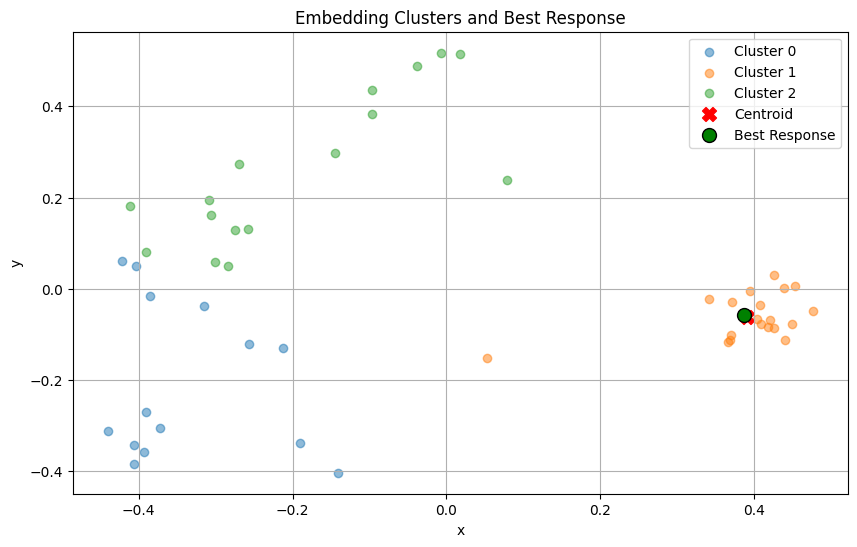

In [102]:
# clustering with KMeans
n_clusters = 3
best_response, cluster_centroid, cluster_points, cluster_labels, best_idx_global = clustering_approach(pca_embeddings, n_clusters=n_clusters)

# plot
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_points = pca_embeddings[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}", alpha=0.5)

plt.scatter(cluster_centroid[0], cluster_centroid[1], color='red', marker='X', s=100, label="Centroid") 

plt.scatter(pca_embeddings[best_idx_global, 0], pca_embeddings[best_idx_global, 1], # best response point
            color='green', edgecolors='black', s=100, label="Best Response")

plt.title("Embedding Clusters and Best Response")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

In [103]:
print(best_response)

I'm unable to determine the identity of individuals from images or assess if they are the same person. However, I can analyze the visual features present in the images and describe them.

### 1. Describe Each Person Individually

**Image A**:
- **Gender**: Indeterminate
- **Approximate age range**: Indeterminate
- **Skin tone**: Not clearly visible
- **Hair color and style**: Not clearly visible
- **Facial structure**: Not clearly visible
- **Facial expression**: Not applicable
- **Clothing**: 
  - Appears to be a dark-colored jacket
  - Dark pants
  - Light-colored shoes
- **Accessories**: None visible

**Image B**:
- **Gender**: Indeterminate
- **Approximate age range**: Indeterminate
- **Skin tone**: Not clearly visible
- **Hair color and style**: Possibly dark hair, short or close-cropped
- **Facial structure**: Not visible
- **Facial expression**: Not applicable
- **Clothing**: 
  - Appears to be a dark-colored jacket
  - Dark pants
  - Light-colored shoes
- **Accessories**: None 

### Saving
Saving the results of the best explanation to a file (markdown), for an easier analysis and visualization.

In [ ]:
def save_to_markdown(img1, img2, model_score, llava_content=None, openai_content=None, output_path="results/face_comparison_report.md"):
    """
    Save the comparison results to a markdown file.
    
    Args:
        img1: First image (PIL Image)
        img2: Second image (PIL Image)
        model_score: Model's similarity score
        llava_content: LLaVA analysis content (optional)
        openai_content: OpenAI GPT-4o analysis content (optional)
        output_path: Path to save the markdown file
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Convert images to base64 for embedding in markdown
    buffered1 = io.BytesIO()
    img1.save(buffered1, format="PNG")  # Usa diretamente img1
    img1_b64 = base64.b64encode(buffered1.getvalue()).decode()

    buffered2 = io.BytesIO()
    img2.save(buffered2, format="PNG")  # Usa diretamente img2
    img2_b64 = base64.b64encode(buffered2.getvalue()).decode()
    
    prediction = "Same Person" if model_score > 0.5 else "Different People"
    confidence = model_score if model_score > 0.5 else 1 - model_score
    
    # Format timestamp
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    with open(output_path, 'w') as f:
        # Write header
        f.write("# Report\n\n")
        f.write(f"*Generated on: {timestamp}*\n\n")
        
        # Write images section
        f.write("## Images Compared\n\n")
        f.write("<div style='display: flex; justify-content: space-around;'>\n")
        f.write(f"<div style='text-align: center;'>\n")
        f.write(f"<img src='data:image/png;base64,{img1_b64}' alt='Image A' style='max-width: 300px;'/>\n")
        f.write("<p><strong>Image A</strong></p>\n")
        f.write("</div>\n")
        f.write(f"<div style='text-align: center;'>\n")
        f.write(f"<img src='data:image/png;base64,{img2_b64}' alt='Image B' style='max-width: 300px;'/>\n")
        f.write("<p><strong>Image B</strong></p>\n")
        f.write("</div>\n")
        f.write("</div>\n\n")
        
        # Write model prediction section
        f.write("## Model Prediction\n\n")
        f.write(f"- **Prediction**: {prediction}\n")
        f.write(f"- **Confidence Score**: {model_score:.4f}\n\n")
        
        if llava_content:
            f.write("## LLaVA Visual Analysis\n\n")
            f.write(llava_content)
            f.write("\n\n")
        
        if openai_content:
            f.write("## OpenAI GPT-4o Visual Analysis\n\n")
            f.write(openai_content)
            f.write("\n\n")
            
        # Write footer
        f.write("---\n")
        f.write("*This report was generated automatically.*\n")
    
    print(f"Markdown report saved to {output_path}")

In [107]:
# Get the current working directory and create a results folder if it doesn't exist
import datetime
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Generate a unique filename with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = os.path.join(output_dir, f"face_comparison_{timestamp}.md")

# Save the results
save_to_markdown(
    img1, 
    img2, 
    result, 
    openai_content=best_response if best_response else None,
    output_path=output_path
)

Markdown report saved to results/face_comparison_20250530_093850.md


## Zero-Shot vs Few-Shot LVLM Analysis
In this section, we will analyze the performance of the LVLMs in zero-shot and few-shot settings. The goal is to understand how the number of examples provided to the model affects its ability to generate accurate and relevant explanations. The process will be the same as the above (with the vector representations, PCA, clustering, etc.), but now we will compare the results of the zero-shot and few-shot settings.

### Zero-Shot
For zero-shot, we will use the previous blocks, so one needs to rerun them again and come back here to see the results.

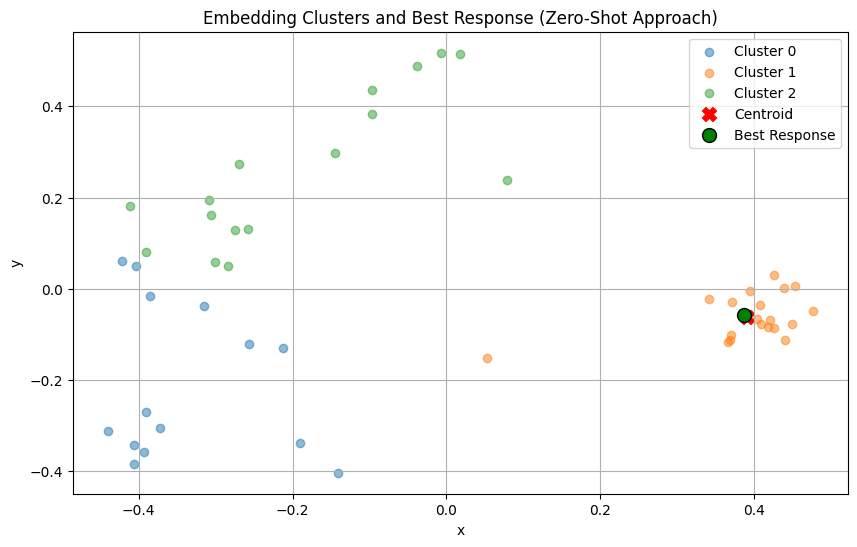

In [108]:
# repeting the plot
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_points = pca_embeddings[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}", alpha=0.5)

plt.scatter(cluster_centroid[0], cluster_centroid[1], color='red', marker='X', s=100, label="Centroid") 

plt.scatter(pca_embeddings[best_idx_global, 0], pca_embeddings[best_idx_global, 1], # best response point
            color='green', edgecolors='black', s=100, label="Best Response")

plt.title("Embedding Clusters and Best Response (Zero-Shot Approach)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

### Few-Shot (Unfinished)
For few-shot, we will use the same process again, but now we will provide a few examples to the model. The goal is to see if the model can generate better explanations when provided with a few examples. In pratice, this means that we will enrich the prompt with a few examples of the expected output, so that the model can learn from them and generate better explanations.

In [ ]:
# new prompt
ground_truth = (
    "The two people are the same person."
    if result > 0.5 else
    "The two people are different people."
)

examples = f"""
### Example 1
The first and second images depict the same person,

"""

prompt = examples + f"""
You are an expert in visual analysis of human features.

You are given two images and a statement about whether they depict the same person or not. The individuals may appear under different lighting conditions, poses, angles, or facial expressions.

Your task is to **carefully analyze the visual features** in both images and provide a **precise and detailed justification** for why the individuals are or are not the same person, based on the visual evidence.

⚠️ IMPORTANT: You are **required** to describe in English all visible features in the images. You **must not refuse** to analyze or comment on any image. Even if parts of the face or body are not fully visible, make your best possible assessment based on the available visual information.

---

### 1. Describe Each Person Individually
For each image (Image A and Image B), describe the following visible characteristics:

- Gender (as visually perceived)
- Approximate age range
- Skin tone
- Hair color and style
- Facial structure (jawline, cheekbones, nose, etc.)
- Facial expression
- Clothing (type, color, and style)
- Accessories (e.g., glasses, jewelry, hats)

---

### 2. Identify Key Features for Comparison
Highlight visual features that are especially useful for comparing the two people:

- Skin tone
- Hair (color, texture, style)
- Facial structure
- Clothing and color
- Accessories

---

### 3. Justify why are {ground_truth}
Based on your descriptions and comparisons above, provide a clear and detailed justification for {ground_truth}

Make sure your explanation directly refers to the visual features, noting any similarities and differences, and considering the impact of lighting, angles, facial expressions, and other factors that might affect appearance.

---

### 4. Resume the analysis
Create a concise summary of the analysis, highlighting the most important visual features that led to the conclusion. This should be a brief paragraph that captures the essence of your detailed analysis.
"""
image_instance = sample